In [1]:
# import plotly.graph_objects as go
# import plotly.express as px
import math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.spatial import ConvexHull

In [98]:
# Model files constants
MYELOID = "myeloid.csv"
CARDIAC = "cardiac.csv"
ERBB = "erbb.csv"
TUMOUR = "tumour.csv"
MAPK = "mapk.csv"

ALL_MODELS = [MYELOID, CARDIAC, ERBB, TUMOUR, MAPK]

# CSV & related plot constants
DNF = 'x'
ATT_COLORS_COL = "Attractor colors"

ONE_STEP_COL = "One-step (ms)"
ONE_STEP_PLT_COLOUR = "blue"
ONE_STEP_MARKER = '.'

PERMANENT_COL = "Permanent (ms)"
PERMANENT_PLT_COLOUR = "red"
PERMANENT_MARKER = '+'

TEMPORARY_COL = "Temporary (ms)"
TEMPORARY_PLT_COLOUR = "#8c6b49"
TEMPORARY_MARKER = '^'

ONE_STEP_OLD_COL = "Old one-step (ms)"
ONE_STEP_OLD_PLT_COLOUR = "green"
ONE_STEP_OLD_MARKER = "x"

ALL_METHOD_COLS = [ONE_STEP_COL, PERMANENT_COL, TEMPORARY_COL]
ALL_METHODS_COLOURS = [ONE_STEP_PLT_COLOUR, PERMANENT_PLT_COLOUR, TEMPORARY_PLT_COLOUR]
ALL_METHODS_MARKERS = [ONE_STEP_MARKER, PERMANENT_MARKER, TEMPORARY_MARKER]

ONE_STEP_METHOD_COLS = [ONE_STEP_COL, ONE_STEP_OLD_COL]
ONE_STEP_METHOD_COLOURS = [ONE_STEP_PLT_COLOUR, ONE_STEP_OLD_PLT_COLOUR]
ONE_STEP_METHOD_MARKERS = [ONE_STEP_MARKER, ONE_STEP_OLD_MARKER]

# Global plot constants

# Attractor colours, roughly based on the MAPK model
X_LIM = 10 ** 10
# Time, based on the timeout (24 hrs ~< 10^8 ms)
Y_LIM = 10 ** 8

# This isn't currently "settable", as most of the code has this base hard-coded
LOG_BASE = 10

In [115]:
def load_model(model_path, method):
    pd.options.mode.chained_assignment = None  # default='warn'
    # TODO: replace results mocking with real ones when available
    if model_path == MAPK and method == TEMPORARY_COL:
        full_results_df = pd.read_csv(model_path)[[ATT_COLORS_COL, ONE_STEP_COL]]
        full_results_df[method] = full_results_df.apply(lambda row: row[ONE_STEP_COL] * 10000, axis=1)
        full_results_df[method] = full_results_df.apply(lambda row: 0 if row[method] > 86400000 else row[method], axis=1)
        full_results_df[method] = full_results_df[method].astype(str)
        full_results_df = full_results_df.replace(to_replace='0', value='x')
    else:
        full_results_df = pd.read_csv(model_path)[[ATT_COLORS_COL, method]]

    full_results_df['is_timeout'] = full_results_df.apply(lambda row: row[method] == DNF, axis=1)

    dnf_df = full_results_df[full_results_df['is_timeout'] == True]
    dnf_df = dnf_df.replace(to_replace=DNF, value=Y_LIM)

    results_df = full_results_df[full_results_df['is_timeout'] == False]
    results_df[method] = pd.to_numeric(results_df[method])
    # Normalize 0ms results to 1ms, to allow logarithmic operations
    results_df = results_df.replace(to_replace=0, value=1)

    return results_df[[ATT_COLORS_COL, method]], dnf_df[[ATT_COLORS_COL, method]]

In [113]:
def generate_scatter(model_path, method, dnf=False):
    cleansed_df, dnf_df = load_model(model_path, method)
    if dnf:
        points_np = np.array(dnf_df.to_numpy())
        return points_np[:, 0], points_np[:, 1]
    else:
        points_np = np.array(cleansed_df.to_numpy())
        return points_np[:, 0], points_np[:, 1]

In [5]:
def generate_log_scatter(model_path, method):
    cleansed_df, _dnf_df = load_model(model_path, method)
    points_np = np.log10(np.array(cleansed_df.to_numpy()))
    # points_np = np.array(cleansed_df.to_numpy())
    return points_np[:, 0], points_np[:, 1]

In [6]:
def generate_labelled_log_scatter(model_path, method):
    cleansed_df, _dnf_df = load_model(model_path, method)
    normalized_df =  cleansed_df.applymap(math.log10)
    normalized_df['label'] = method.removesuffix(" (ms)")
    return normalized_df.rename(columns={method: 'Time (ms)'})

In [7]:
def generate_hull(model_path, method):
    cleansed_df, _dnf_df = load_model(model_path, method)
    points_np = np.log10(np.array(cleansed_df.to_numpy()))
    hull = points_np[ConvexHull(points_np).vertices]
    bases = np.full_like(hull, LOG_BASE)
    hull_original_coors = np.power(bases, hull)
    hull_full_shape = np.vstack((hull_original_coors, hull_original_coors[0]))
    return hull_full_shape[:, 0], hull_full_shape[:, 1]

In [137]:
def generate_hull_plot(model_path, method, method_colour, method_marker, x_lim, y_lim, axe):
    x, y = generate_hull(model_path, method)
    x_s, y_s = generate_scatter(model_path, method)

    if method == ONE_STEP_OLD_COL:
        axe.set_title("One-step (semi-symbolic)")
    else:
        axe.set_title(method.removesuffix("(ms)"))

    axe.set_xscale('log')
    axe.set_xlim(1, x_lim)
    axe.set_xlabel('Attractor colours')

    axe.set_yscale('log')
    axe.set_ylim(1, y_lim)
    axe.set_ylabel('Time (ms)')

    axe.fill(x, y, facecolor='None', edgecolor=method_colour, linewidth=1, alpha=0.2)
    axe.fill(x, y, facecolor=method_colour, alpha=0.05)

    axe.scatter(x_s, y_s, marker=method_marker, facecolor=method_colour, s=15)

    dnf_x_s, dnf_y_s = generate_scatter(model_path, method, dnf=True)
    axe.scatter(dnf_x_s, dnf_y_s, marker='x', facecolor='black', s=15, zorder=10, clip_on = False)

In [163]:
def generate_plots(models, methods, colours, markers, suffix):

    for model in models:
        fig, axs = plt.subplots(1, len(methods) + 1)

        # Plot all measurements for each of the methods
        for i in range(len(methods)):
            generate_hull_plot(model, methods[i], colours[i], markers[i], X_LIM, Y_LIM, axs[i])

        # Prepare the regression plot
        regression_ix = len(methods)
        axs[regression_ix].set_title("All")
        axs[regression_ix].set_xlim(0, math.log(X_LIM, 10))
        axs[regression_ix].set_ylim(0, math.log(Y_LIM, 10))
        axs[regression_ix].set_xlabel('Attractor colours')
        axs[regression_ix].set_ylabel('Time (ms)')

        # Draw the scatter & regression for each of the methods
        for i in range(len(methods)):
            x, y = generate_log_scatter(model, methods[i])
            sns.regplot(x=x, y=y, color=colours[i], marker=markers[i], ci=None, scatter_kws={"s": 8}, ax=axs[regression_ix])

        # Fix axes ticks
        for i in range(len(axs)):
            axs[i].set_clip_on(False)
            # axs[i].set_zorder(2)

            x_ticks = range(0, 11, 2)
            y_ticks = range(0, 9, 2)
            if i == regression_ix:
                # Last plot == regression plot
                # Regression plot has just exponent in its original representation
                axs[i].set_xticks([float(t) for t in x_ticks], [f'$10^{{{t}}}$' for t in x_ticks])
                axs[i].set_yticks([float(t) for t in y_ticks], [f'$10^{{{t}}}$' for t in y_ticks])
            else:
                axs[i].set_yticks([10.0 ** float(t) for t in y_ticks], [f'$10^{{{t}}}$' for t in y_ticks])
                axs[i].set_xticks([10.0 ** float(t) for t in x_ticks], [f'$10^{{{t}}}$' for t in x_ticks])

        fig.set_clip_on(False)
        # Export
        fig.subplots_adjust(top=0.9,
                        bottom=0.15,
                        left=0.05,
                        right=0.98,
                        wspace=0.3)
        fig.set_size_inches(4*(len(methods)+1), 3.3)
        fig.set_dpi(300)
        fig.savefig(f'{model.removesuffix(".csv")}_{suffix}.pdf')

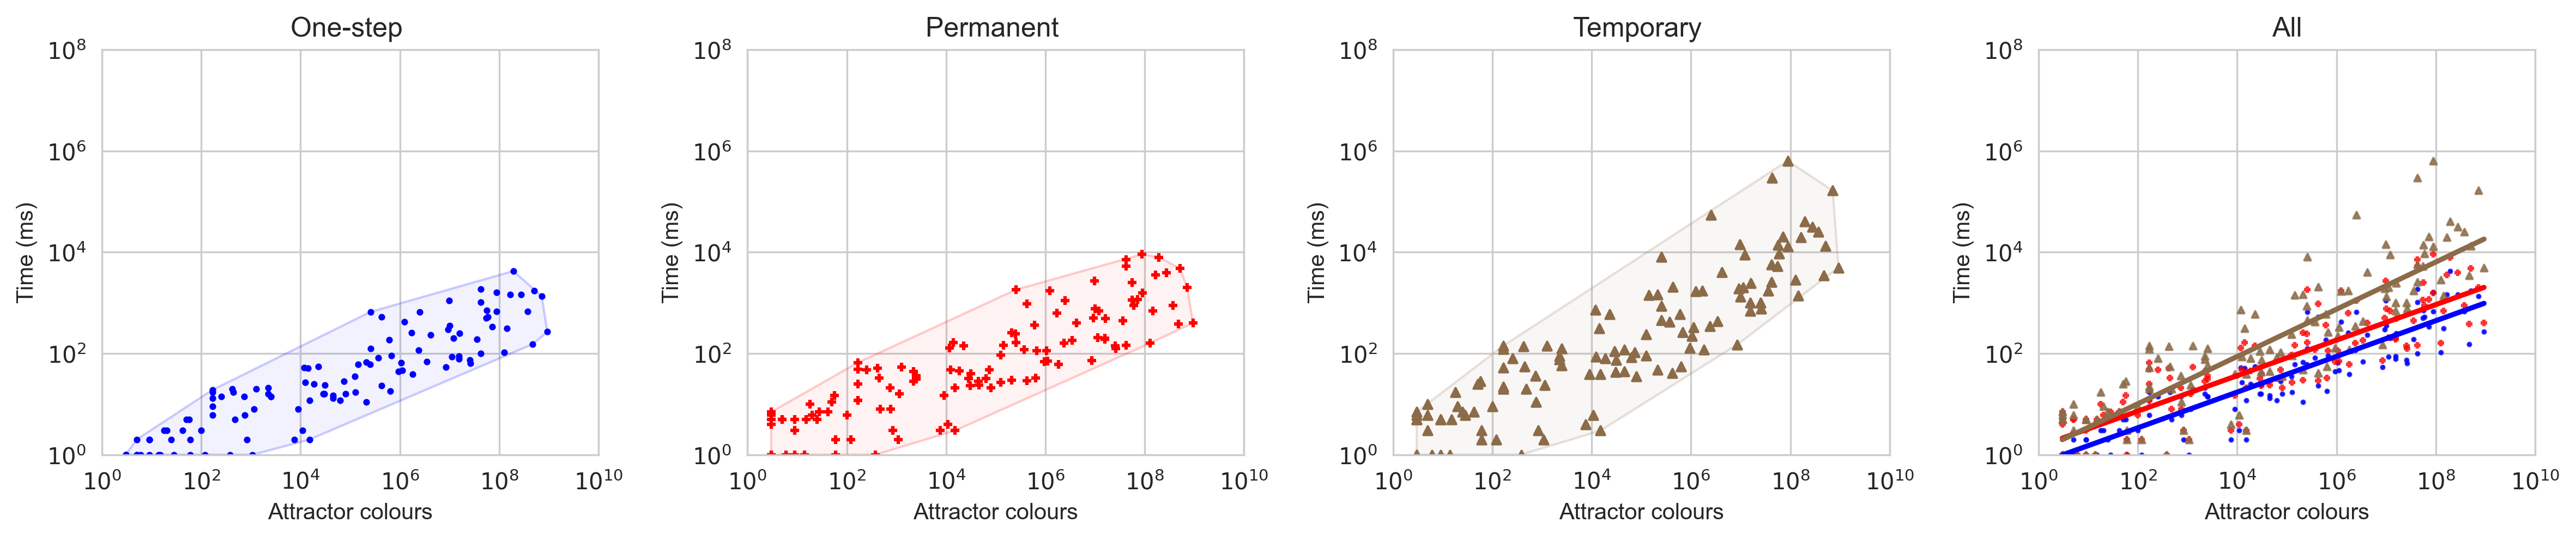

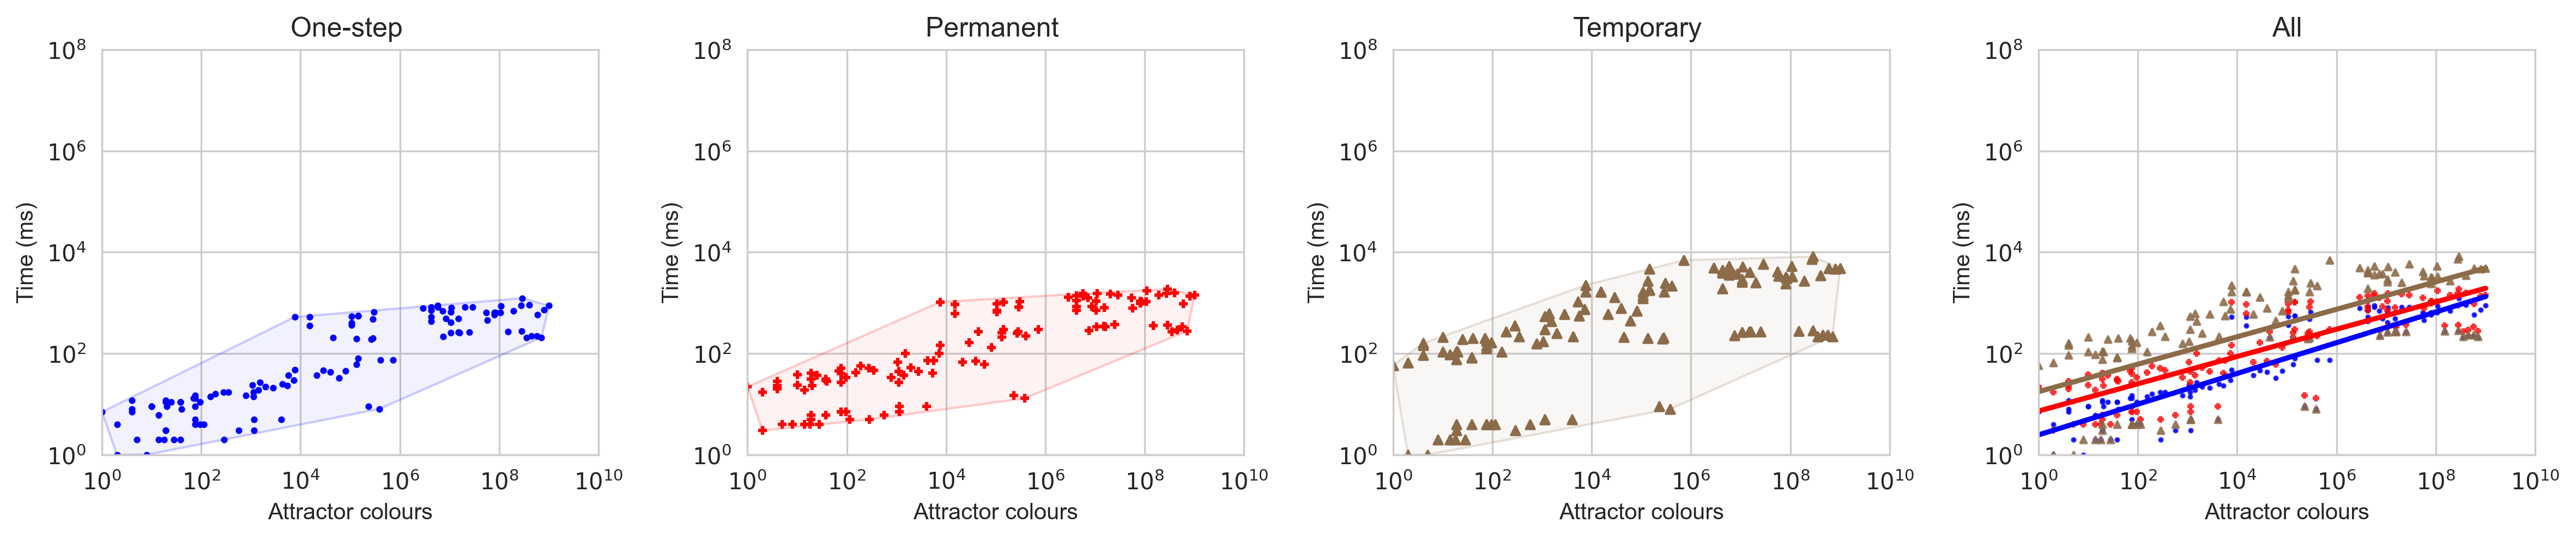

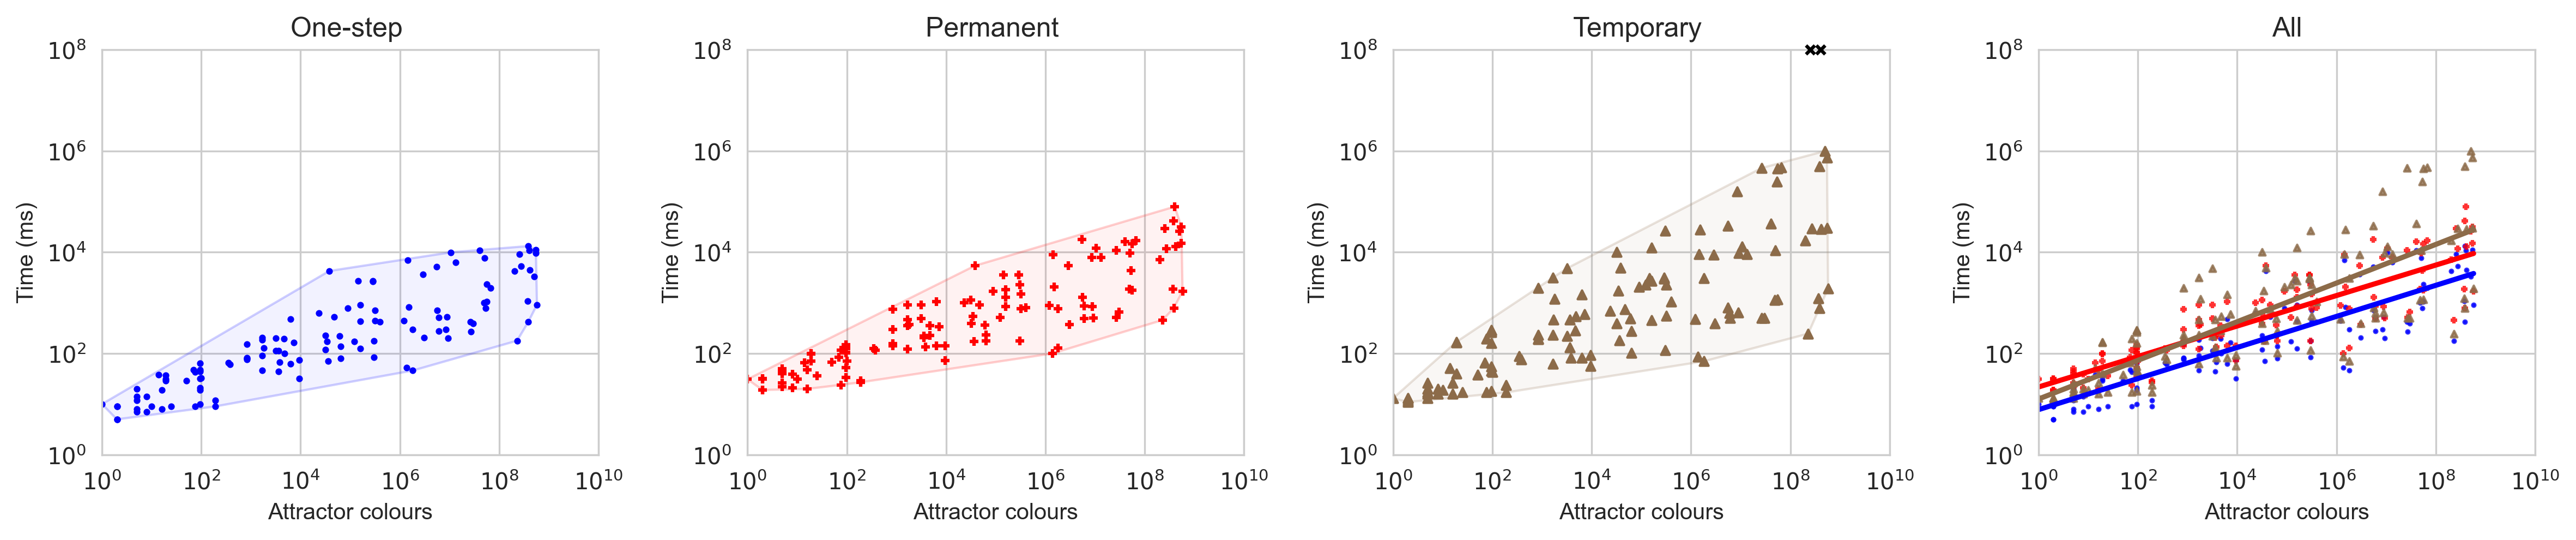

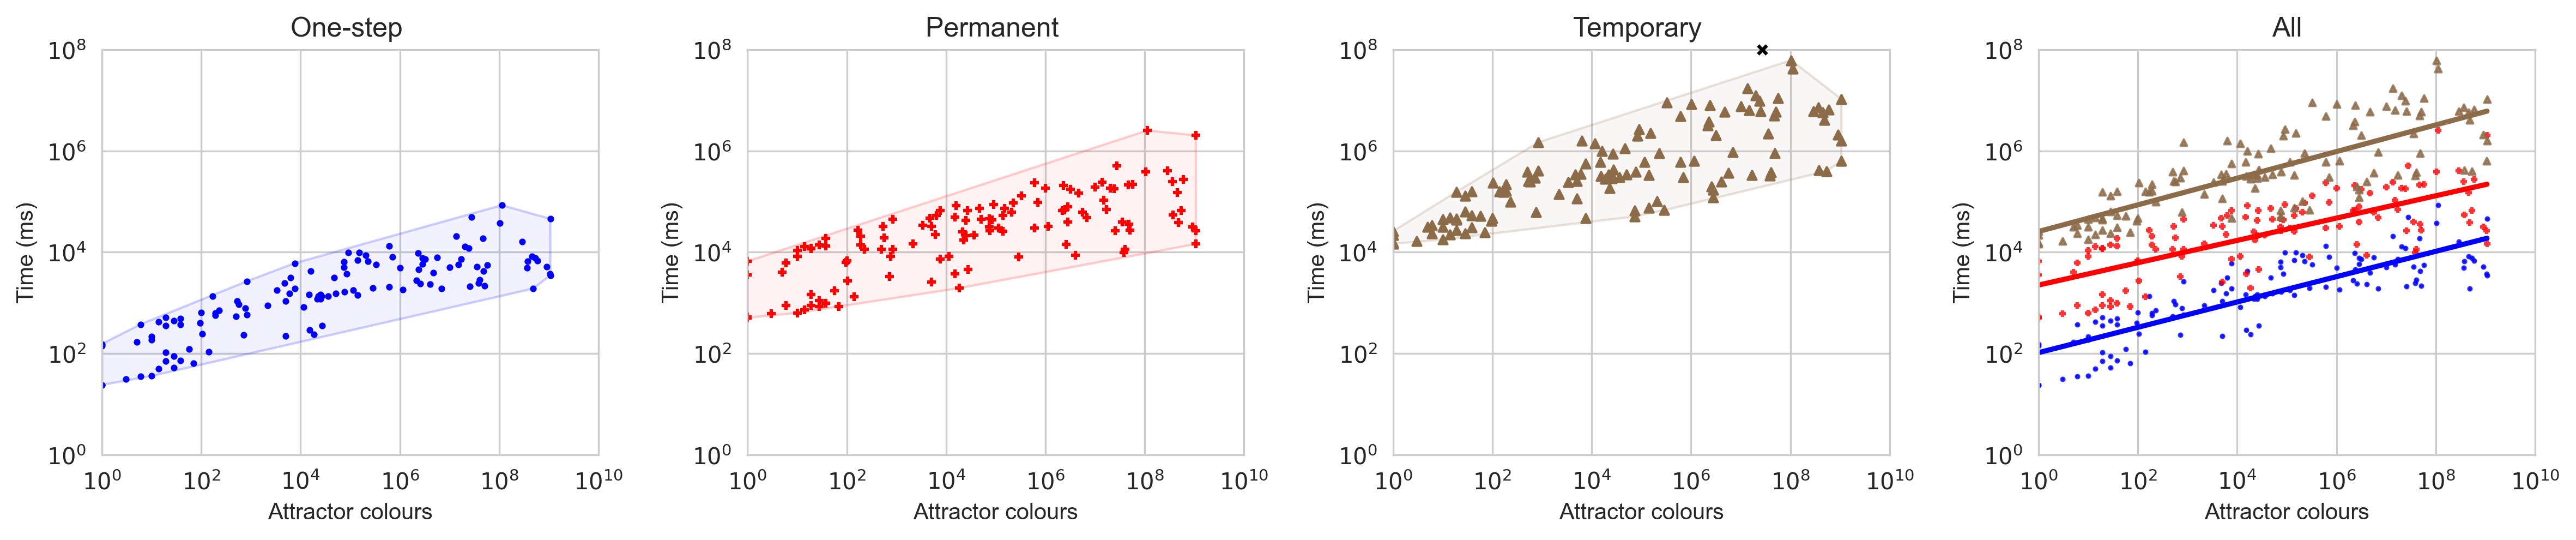

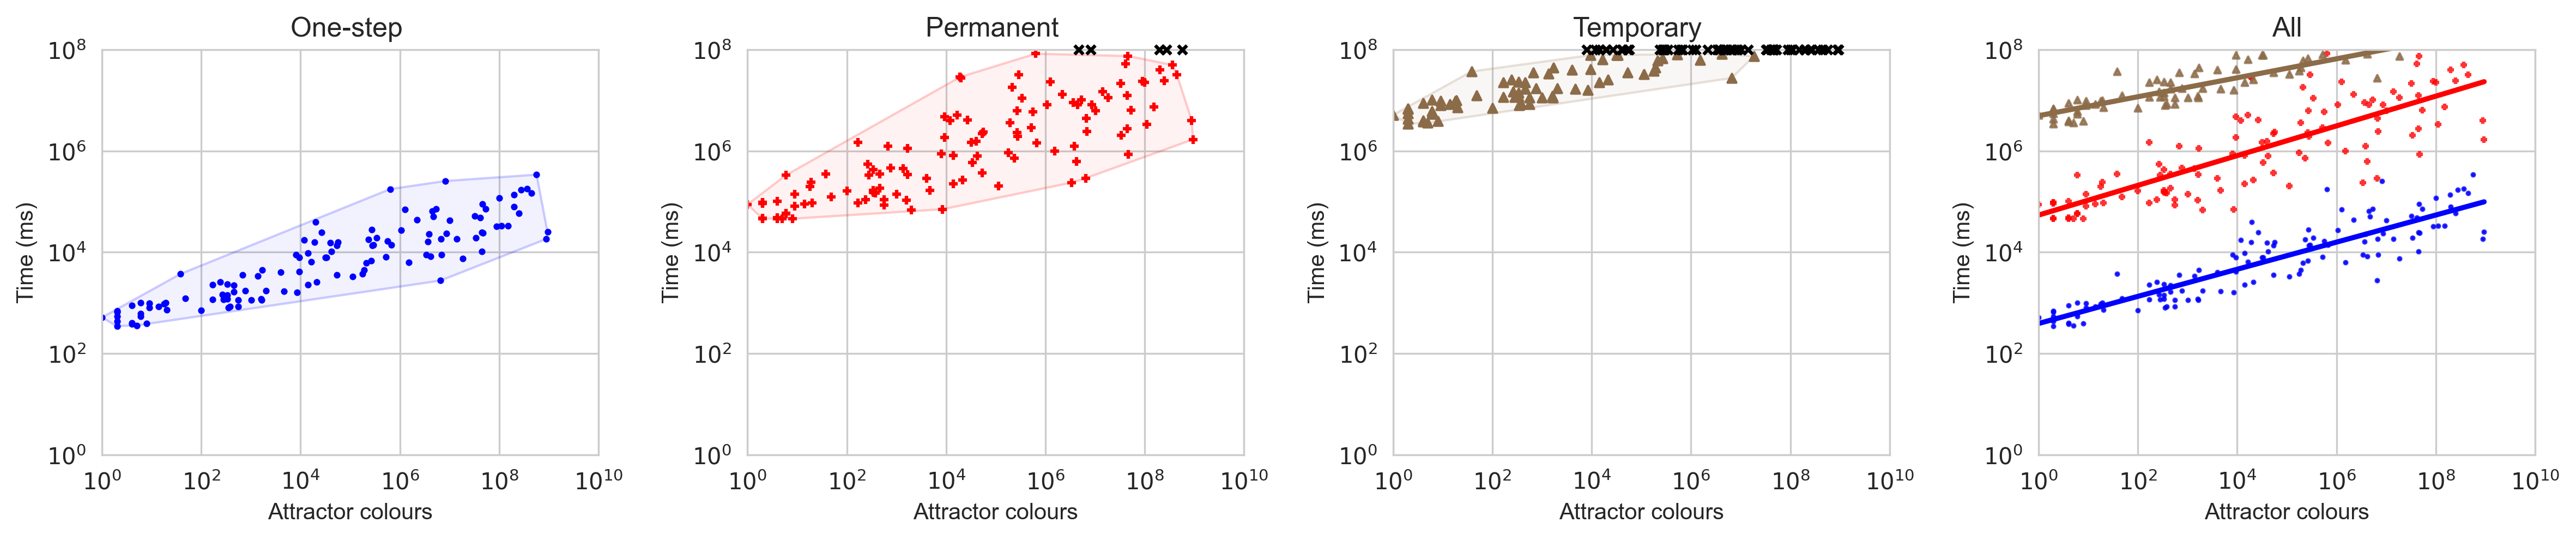

In [165]:
generate_plots(ALL_MODELS, ALL_METHOD_COLS, ALL_METHODS_COLOURS, ALL_METHODS_MARKERS, "all")

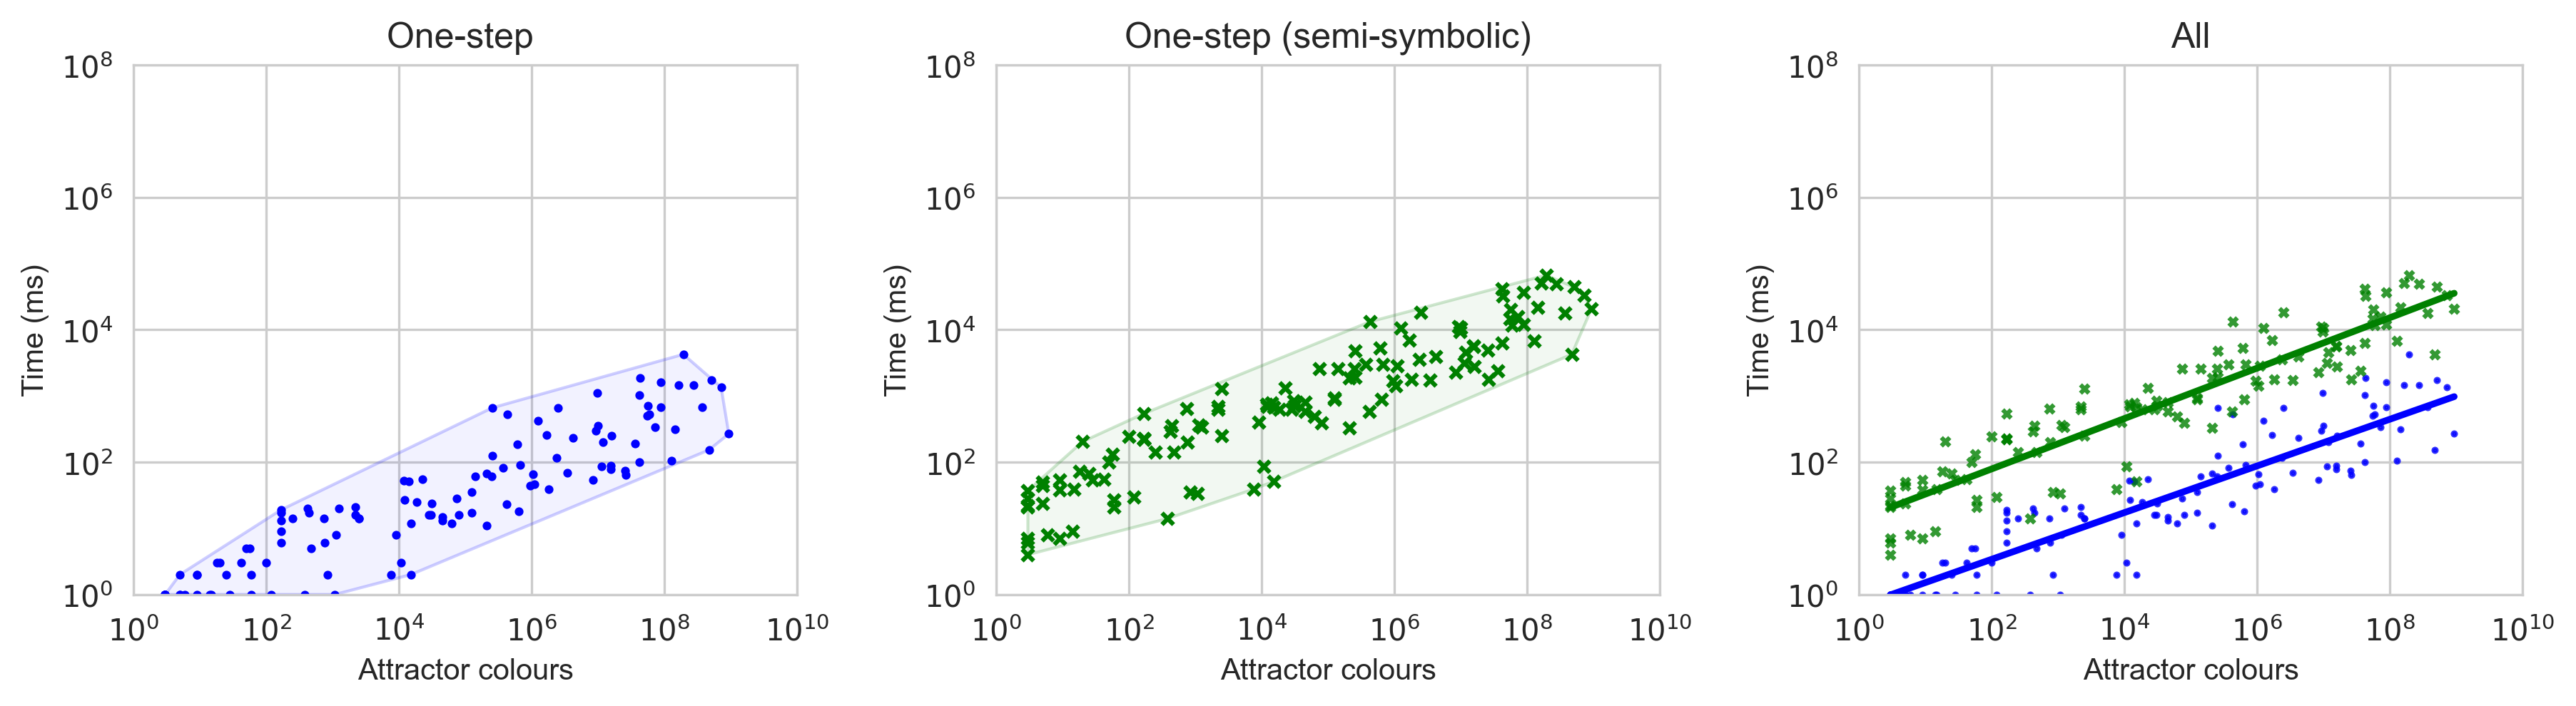

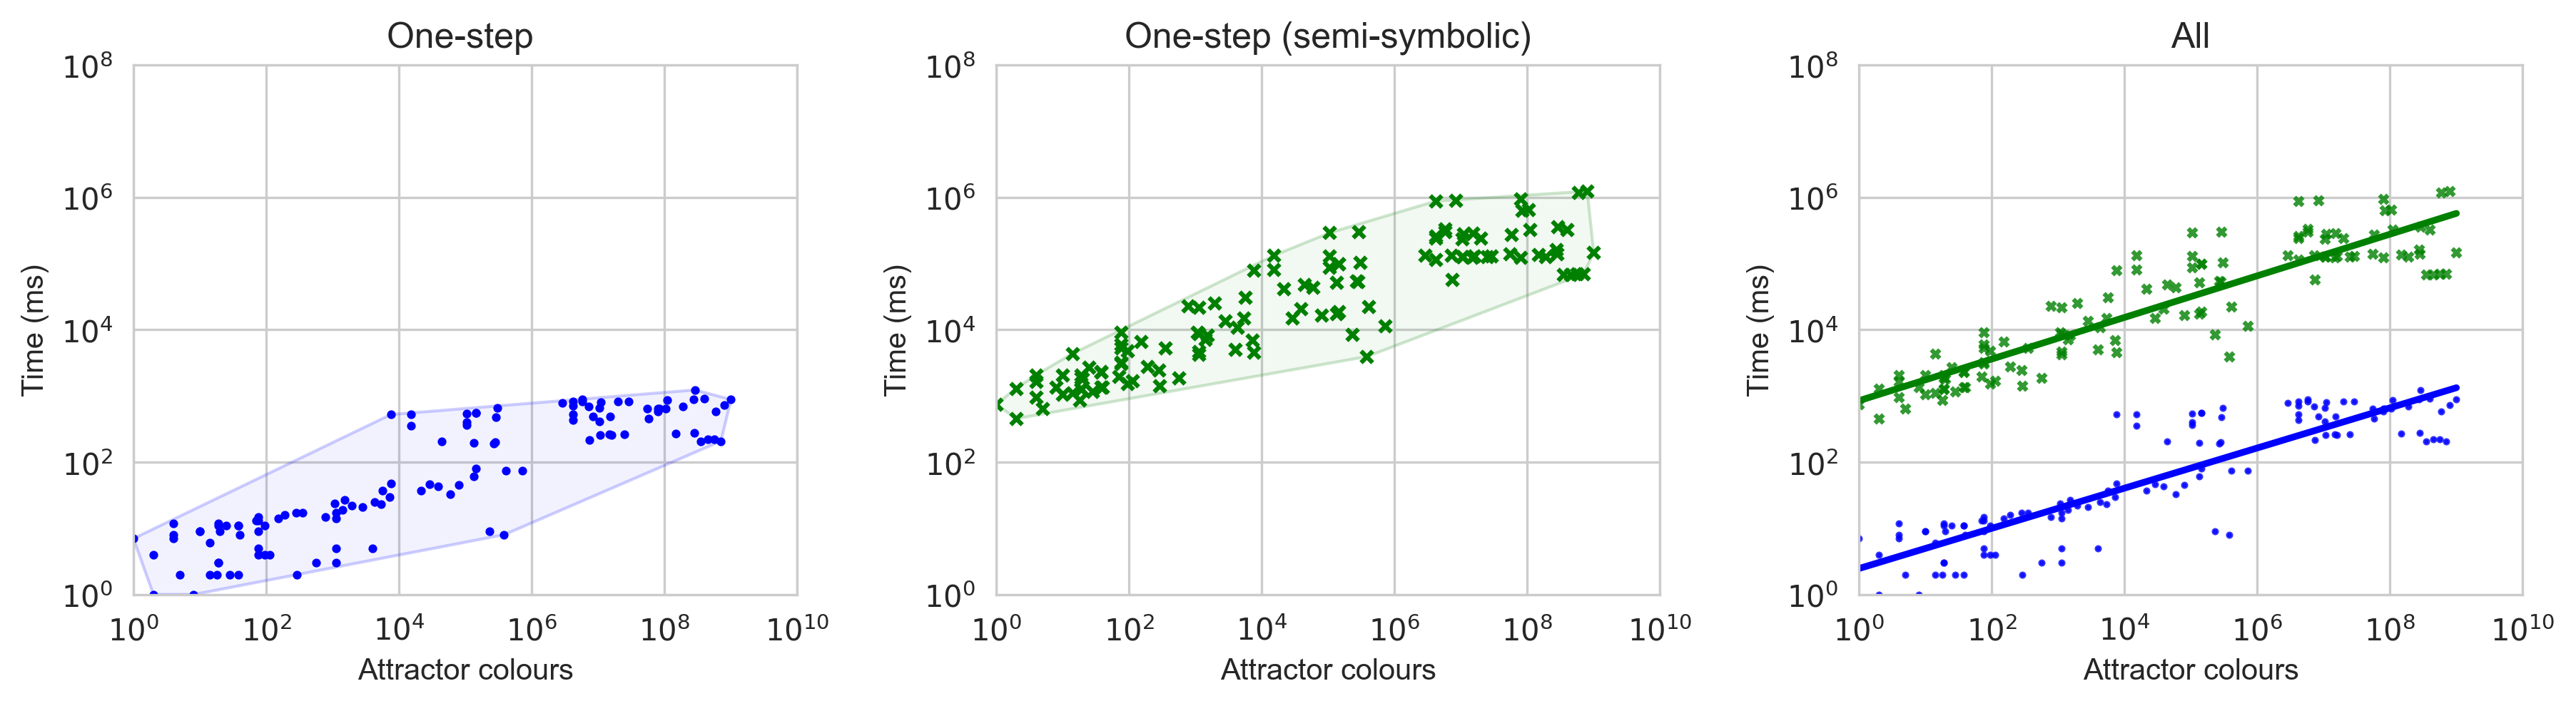

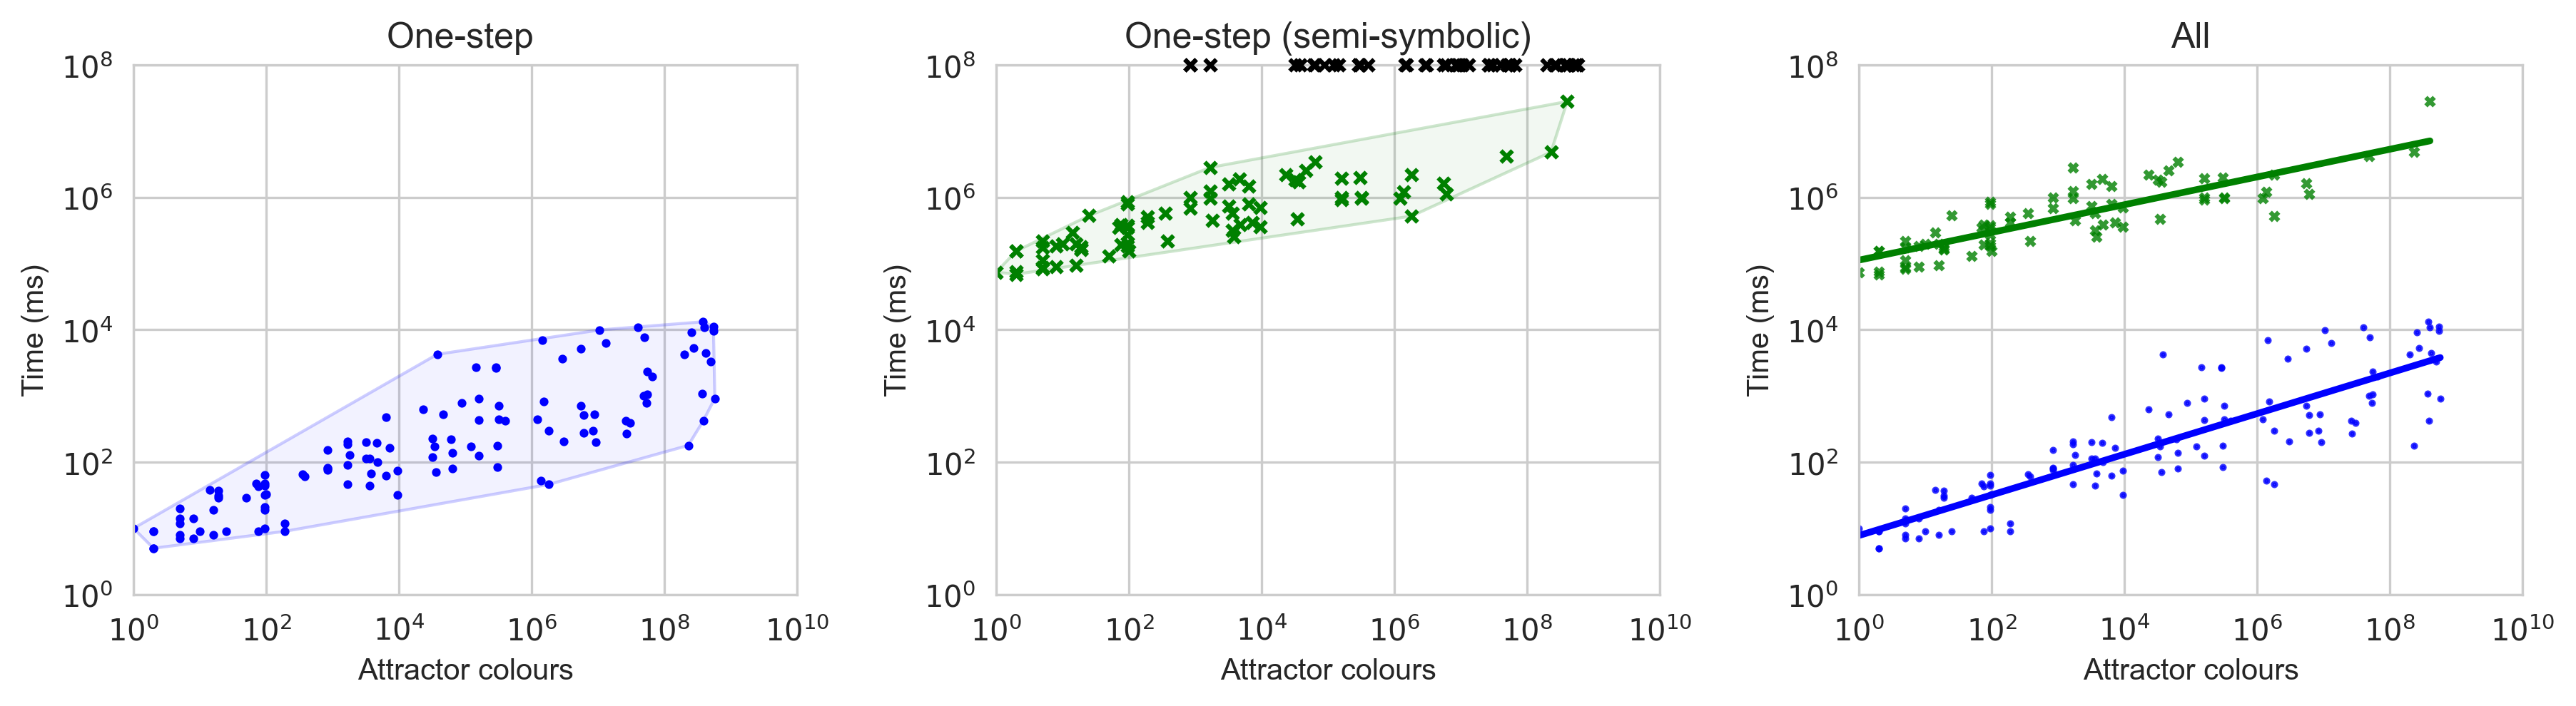

In [166]:
generate_plots([MYELOID, CARDIAC, ERBB], ONE_STEP_METHOD_COLS, ONE_STEP_METHOD_COLOURS, ONE_STEP_METHOD_MARKERS, "os")